## StableBaselines3 results

https://colab.research.google.com/drive/1PnrsH-dCyF5aODincGGIUAVulAVah6ia#scrollTo=mqM1GsEEgORl

[Yuzhong Code](https://github.com/YizhongHu/rocket_circularization/blob/master/rocket_gym.py)

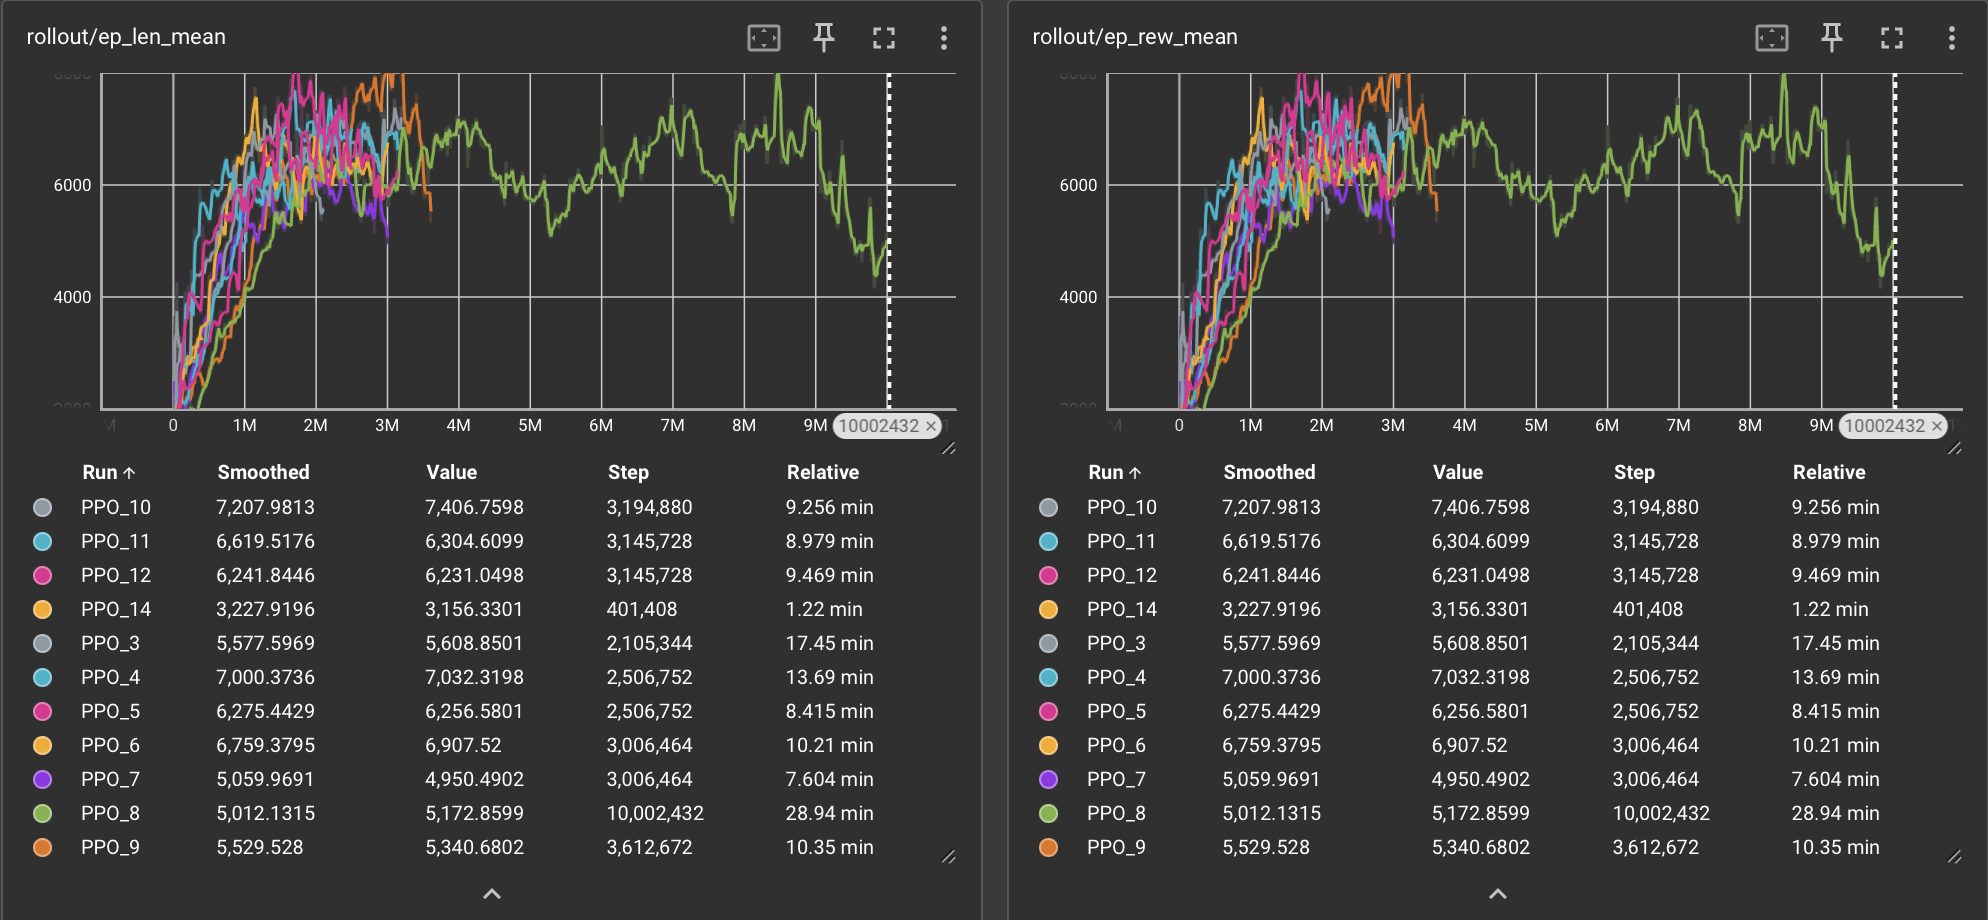

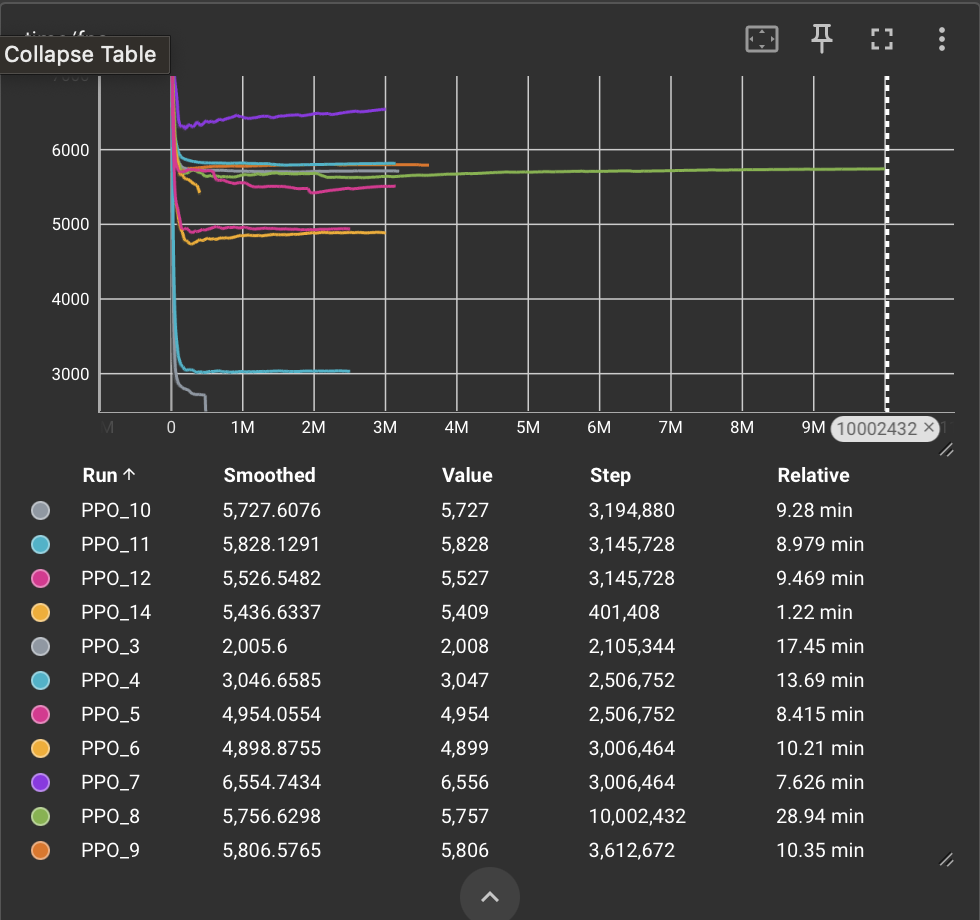

learned activation space at 3.5 million episodes of training (~5k survival rate with make episode length of 10k)

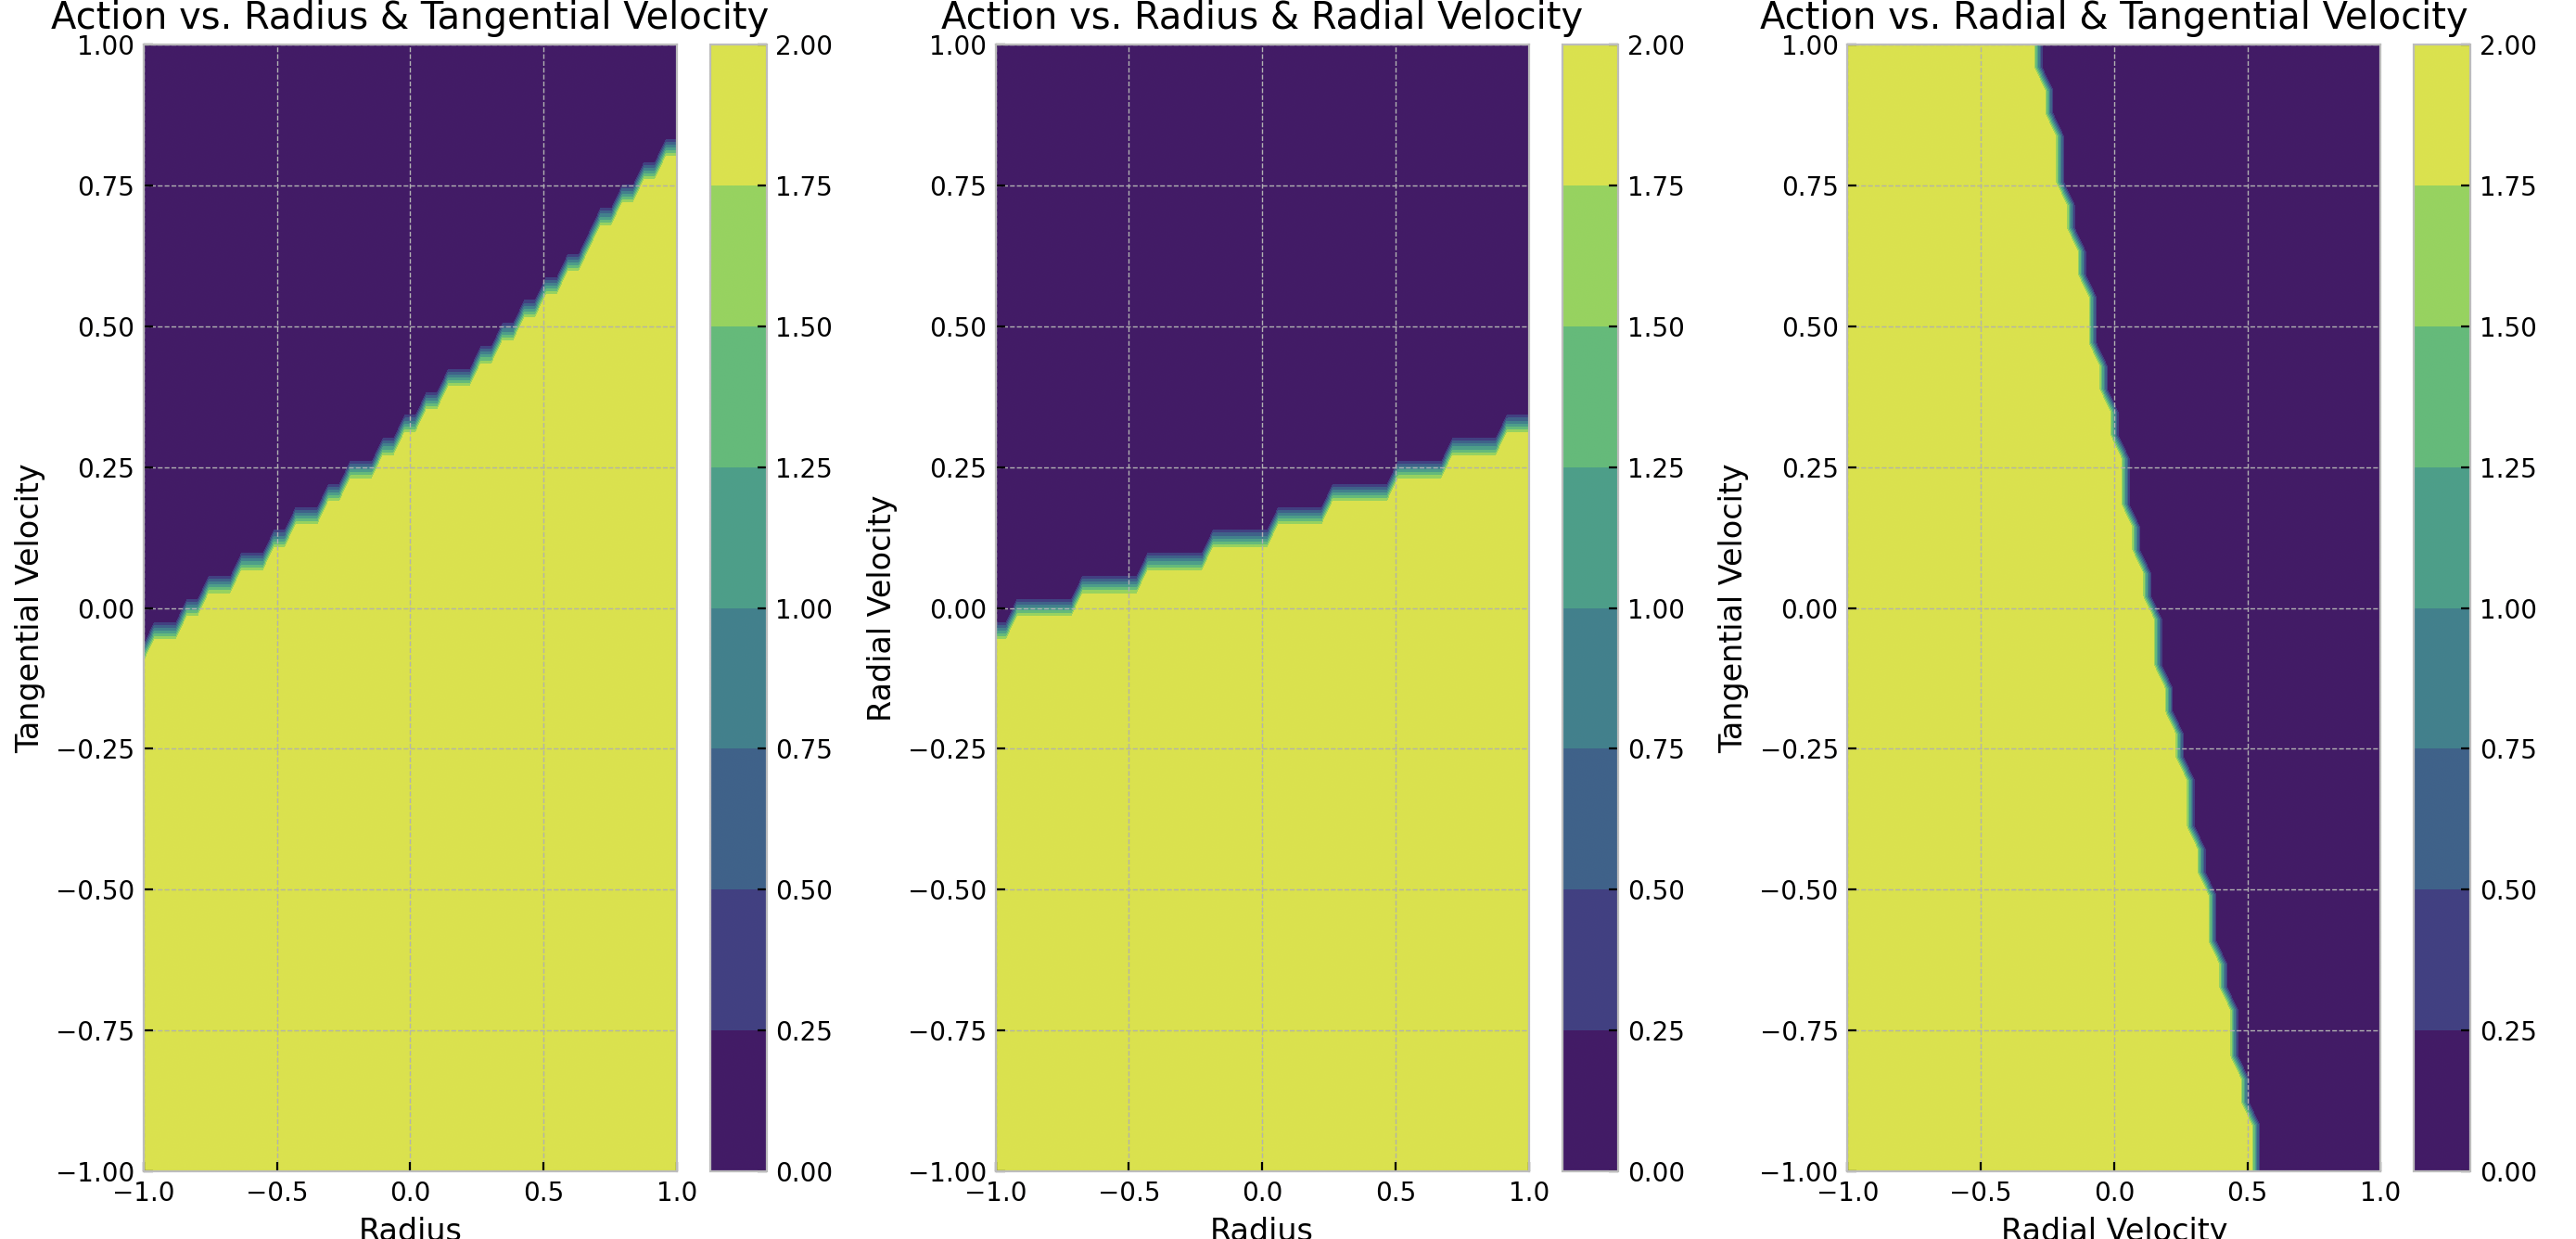

In [ ]:
!git clone https://github.com/YizhongHu/rocket_circularization
!cp -r rocket_circularization/* ./

import gym
import rocket_gym
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, List, Sequence, Tuple
import torch as th
import stable_baselines3
from stable_baselines3 import PPO, A2C, DQN, SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.noise import NormalActionNoise
import tensorflow as tf

# Initialize and wrap the environment
env_name = 'RocketCircularization-v1'
env = rocket_gym.make(env_name)
env.max_step = 10_000  # maximum episode length
env = rocket_gym.PolarizeAction(env)
env = rocket_gym.RadialThrust(env)
env = rocket_gym.PolarizeObservation(env)

# Examine the observation space after wrapping
env.observation_space = gym.spaces.Box(low=-10, high=10, shape=(3,), dtype=np.float32) # <- possible source of error
print("Observation space:", env.observation_space)
print("Sample observation:", env.reset())

# Set up vectorized environment
env = make_vec_env(lambda: env, n_envs=4)

# Initialize PPO model
policy_kwargs = dict(activation_fn=th.nn.SiLU, net_arch=dict(pi=[48, 48, 48, 48, 48, 48], vf=[48, 48, 48, 48, 48, 48]))
model = PPO("MlpPolicy", env, batch_size=1024, gamma=0.995, policy_kwargs=policy_kwargs, tensorboard_log="./ppo_rocketCircularization_tensorboard/", verbose=1)

# Check if the model starts learning without error
try:
    model.learn(total_timesteps=3_500_000, progress_bar=True)
    print("Model training started successfully!")
except Exception as e:
    print("Error during training:", e)

# Save the model
model.save("ppo_rocket_circularization")

# Optionally, evaluate the model here using evaluation environments or other metrics

# Load the model
model = PPO.load("ppo_rocket_circularization")

# Function to evaluate model across a grid of states
def evaluate_action_grid(model, grid_size=50, state_dims=(0, 2)):
    x = np.linspace(-1, 1, grid_size)
    y = np.linspace(-1, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    # Select the third index to set as zero based on unused dimension
    zero_idx = 3 - sum(state_dims)  # sum of indices 0, 1, 2 is 3, so this gives the remaining one

    for i in range(grid_size):
        for j in range(grid_size):
            obs = np.zeros(3)
            obs[state_dims[0]] = X[i, j]
            obs[state_dims[1]] = Y[i, j]
            action, _states = model.predict(obs.reshape(1, -1), deterministic=True)
            Z[i, j] = action[0]

    return X, Y, Z

# Generate action grid
X02, Y02, action_grid02 = evaluate_action_grid(model, state_dims=(0, 2))
X01, Y01, action_grid01 = evaluate_action_grid(model, state_dims=(0, 1))
X12, Y12, action_grid12 = evaluate_action_grid(model, state_dims=(1, 2))

# Plotting
plt.figure(figsize=(15, 10))

# State[0] vs State[2] (original)
plt.subplot(1, 3, 1)
contour = plt.contourf(X02, Y02, action_grid02.squeeze(), cmap='viridis')
plt.colorbar(contour)
plt.xlabel('Radius')
plt.ylabel('Tangential Velocity')
plt.title('Action vs. Radius & Tangential Velocity')

# State[0] vs State[1]
plt.subplot(1, 3, 2)
contour = plt.contourf(X01, Y01, action_grid01.squeeze(), cmap='viridis')
plt.colorbar(contour)
plt.xlabel('Radius')
plt.ylabel('Radial Velocity')
plt.title('Action vs. Radius & Radial Velocity')

# State[1] vs State[2]
plt.subplot(1, 3, 3)
contour = plt.contourf(X12, Y12, action_grid12.squeeze(), cmap='viridis')
plt.colorbar(contour)
plt.xlabel('Radial Velocity')
plt.ylabel('Tangential Velocity')
plt.title('Action vs. Radial & Tangential Velocity')

plt.tight_layout()
plt.show()

## Local Training Loop results...

In [ ]:
!git clone https://github.com/YizhongHu/rocket_circularization
!cp -r rocket_circularization/* ./

import rocket_gym

import os
import math
import time
import glob
import random
import numpy as np
import pandas as pd

import gym
from gym import spaces, logger
from gym.utils import seeding
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

from datetime import datetime
from typing import Optional, Union

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from IPython.display import HTML

fatal: destination path 'rocket_circularization' already exists and is not an empty directory.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/content/animation.py:217: DeprecationWarning: invalid escape sequence '\h'
  ax.set_title('Thrust Direction (Angle from $\hat{r}$)')
/content/animation.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


In [ ]:
# Memory to storing history of transitions
class ReplayBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


# One model with the Actor *and* Critic networks bundled together
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()
        # Works now for both continuous and discrete action states
        self.has_continuous_action_space = has_continuous_action_space
        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init)

        # Actor
        if has_continuous_action_space :
            # Output range [-1, 1]

            self.actor = nn.Sequential(
                            nn.Linear(state_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, action_dim),
                            nn.Tanh())
        else:
            # Output discrete n = action_dim actions
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, action_dim),
                            nn.Softmax(dim=-1))

        # Critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, 1))


    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std)
        else:
          print("WARNING : Called ActorCritic::set_action_std() on discrete action space")


    def act(self, state):
        if self.has_continuous_action_space:
            action_mean = self.actor(state) # mean of action predicted by actor
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
             # generate distribution to draw actions from based on learned uncertainty in action
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample() # get action from distribution (adds randomness)
        action_logprob = dist.log_prob(action) # get prob of the action which was drawn for adjusting actor weights
        state_val = self.critic(state) # expected critic network value of state for adjusting critic weights

        return action.detach(), action_logprob.detach(), state_val.detach()


    def evaluate(self, state, action):
        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var)
            dist = MultivariateNormal(action_mean, cov_mat)
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, hidden_dim, lr_actor, lr_critic, gamma, epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):
        self.has_continuous_action_space = has_continuous_action_space
        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma # discount of past reward
        self.eps_clip = eps_clip # for clipping values to prevent math issues
        self.epochs = epochs
        self.memory = ReplayBuffer()
        self.policy = ActorCritic(state_dim, action_dim, hidden_dim, has_continuous_action_space, action_std_init)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor, 'betas': (0.99, 0.99)},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic, 'betas': (0.99, 0.99)}
                    ])
        self.policy_old = ActorCritic(state_dim, action_dim, hidden_dim, has_continuous_action_space, action_std_init)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        else:
            print("WARNING : Called PPO::set_action_std() on discrete action space")


    def decay_action_std(self, action_std_decay_rate, min_action_std):

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Called PPO::decay_action_std() on discrete action space")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.memory.states.append(state)
            self.memory.actions.append(action)
            self.memory.logprobs.append(action_logprob)
            self.memory.state_values.append(state_val)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.memory.states.append(state)
            self.memory.actions.append(action)
            self.memory.logprobs.append(action_logprob)
            self.memory.state_values.append(state_val)

            return action.item()


    def update(self):
        # Construct Discounted Sum of Rewards
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.memory.rewards), reversed(self.memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing Rewards
        rewards = torch.tensor(rewards, dtype=torch.float32)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # List -> Tensor
        old_states = torch.squeeze(torch.stack(self.memory.states, dim=0)).detach()
        old_actions = torch.squeeze(torch.stack(self.memory.actions, dim=0)).detach()
        old_logprobs = torch.squeeze(torch.stack(self.memory.logprobs, dim=0)).detach()
        old_state_values = torch.squeeze(torch.stack(self.memory.state_values, dim=0)).detach()

        advantages = rewards.detach() - old_state_values.detach()

        for k in range(self.epochs):
            print(f"\rtraining epoch: {k}", end="")

            # Evaluate old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            state_values = torch.squeeze(state_values)

            # Use PPO conservative weight adjustments
            ratios = torch.exp(logprobs - old_logprobs.detach())
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy

            self.optimizer.zero_grad()
            loss.mean().backward()
            print(f"{round(loss.mean().item(), 5)}", end="")
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())
        self.memory.clear()

    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

In [ ]:
def train():
    print("============================================================================================")

    ####### setup #######
    has_continuous_action_space = True  # continuous action space; else discrete
    max_ep_len = 20_000                 # max timesteps in one episode
    max_training_timesteps = 2_000_000  # break training loop if timeteps > max_training_timesteps
    print_freq = max_ep_len * 5         # how often (in timesteps) to print avg reward
    log_freq = max_ep_len * 5           # how often (in timesteps) to print log avg reward
    save_model_freq = max_ep_len * 15   # how often (in timesteps) to save model
    update_timestep = max_ep_len        # how often (in timesteps) to update policy

    epochs = 501                         # how many (in epochs) to run on updating PPO
    eps_clip = 0.2                      # parameter for value clipping

    action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
    action_std_decay_rate = 0.05        # action_std = action_std - action_std_decay_rate
    min_action_std = 0.1                # minimum action_std
    action_std_decay_freq = 250_000     # how often (in timesteps) to decay action_std
    gamma = 0.99                        # discount factor for considering past summed rewards in value of current state
    lr_actor = 5e-4                     # lr for actor
    lr_critic = 5e-4                    # lr for critic
    hidden_dim = 24

    random_seed = 0                     # seed (can be set to random number, currently set to 0)

    env_name = "RocketCircularization-v1" # env name to save model under
    print("training environment name : " + env_name)

    env = rocket_gym.make('RocketCircularization-v1')       # <- Using Custom Env
    env.max_step = 400
    env.seed()

    state_dim = env.observation_space.shape[0] # state dimension
    if has_continuous_action_space:            # action dimension
        action_dim = env.action_space.shape[0]
    else:
        action_dim = env.action_space.n


    ####### logging #######
    # don't overwrite old log files
    log_dir = "PPO_logs"
    if not os.path.exists(log_dir):
          os.makedirs(log_dir)
    log_dir = log_dir + '/' + env_name + '/'
    if not os.path.exists(log_dir):
          os.makedirs(log_dir)

    # num of log files in log directory
    run_num = 0
    current_num_files = next(os.walk(log_dir))[2]
    run_num = len(current_num_files)

    # new log file for current run
    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"
    print("current logging run number for " + env_name + " : ", run_num)
    print("logging at : " + log_f_name)


    ####### checkpointing #######
    # don't overwrite old weights
    run_num_pretrained = 0

    directory = "PPO_preTrained"
    if not os.path.exists(directory):
          os.makedirs(directory)
    directory = directory + '/' + env_name + '/'
    if not os.path.exists(directory):
          os.makedirs(directory)

    checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
    print("save checkpoint path : " + checkpoint_path)

    if random_seed:
        torch.manual_seed(random_seed)
        env.seed(random_seed)
        np.random.seed(random_seed)

    ####### training procedure #######
    ppo_agent = PPO(state_dim, action_dim, hidden_dim, lr_actor, lr_critic, gamma, epochs, eps_clip, has_continuous_action_space, action_std)
    start_time = datetime.now().replace(microsecond=0)

    print("Started training at (GMT) : ", start_time)
    print("============================================================================================")

    # log episode, timestep, reward throughout trainking
    log_f = open(log_f_name,"w+")
    log_f.write('episode,timestep,reward\n')
    print_running_reward = 0
    print_running_episodes = 0
    log_running_reward = 0
    log_running_episodes = 0

    # training loop

    rewards = []

    time_step = 0
    i_episode = 0
    while time_step <= max_training_timesteps:
        state = env.reset()
        env.seed()

        current_ep_reward = 0
        for t in range(1, max_ep_len+1):
            print(f"\rStep: {t} \t [{time_step % print_freq}/{print_freq}]", end="")

            # select action
            action = ppo_agent.select_action(state)
            state, reward, done, truncated, info = env.step(action)

            done = done or truncated
            scale_of_thrust = np.linalg.norm(action, ord=1) / 10
            reward = 1 - scale_of_thrust

            # register new step
            ppo_agent.memory.rewards.append(reward)
            ppo_agent.memory.is_terminals.append(done)
            time_step +=1
            current_ep_reward += reward

            print_avg_reward = print_running_reward / print_running_episodes if print_running_episodes != 0 else 0
            print_avg_reward = round(print_avg_reward, 2)

            # update PPO agent
            if time_step % update_timestep == 0:
                ppo_agent.update()

            # decay action_std when necessary
            if has_continuous_action_space and time_step % action_std_decay_freq == 0:
                ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

            # log in logging file
            if time_step % log_freq == 0:
                log_avg_reward = log_running_reward / log_running_episodes
                log_avg_reward = round(log_avg_reward, 4)
                log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
                log_f.flush()
                log_running_reward = 0
                log_running_episodes = 0

            # print avg reward
            if time_step % print_freq == 0:
                print("\tEpisode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))
                print_running_reward = 0
                print_running_episodes = 0

            # save weights
            if time_step % save_model_freq == 0 and print_avg_reward == max_ep_len:
                print("--------------------------------------------------------------------------------------------")
                print("saving model at : " + checkpoint_path)
                ppo_agent.save(checkpoint_path)
                time_step = max_training_timesteps
                print("model saved")
                print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
                print("--------------------------------------------------------------------------------------------")

            if done:
                rewards.append(current_ep_reward)
                break

        print_running_reward += current_ep_reward
        print_running_episodes += 1
        log_running_reward += current_ep_reward
        log_running_episodes += 1
        i_episode += 1

    log_f.close()
    env.close()

    # print total training time
    print("============================================================================================")
    end_time = datetime.now().replace(microsecond=0)
    print("Finished training at (GMT) : ", end_time)
    print("Total training time  : ", end_time - start_time)
    print("============================================================================================")

    return rewards

rewards = train()

training environment name : RocketCircularization-v1
current logging run number for RocketCircularization-v1 :  19
logging at : PPO_logs/RocketCircularization-v1//PPO_RocketCircularization-v1_log_19.csv
save checkpoint path : PPO_preTrained/RocketCircularization-v1/PPO_RocketCircularization-v1_0_0.pth
Started training at (GMT) :  2024-04-19 20:45:13
training epoch: 500	Episode : 646 		 Timestep : 100000 		 Average Reward : 139.23
training epoch: 500	Episode : 1201 		 Timestep : 200000 		 Average Reward : 162.6
training epoch: 500	Episode : 1749 		 Timestep : 300000 		 Average Reward : 164.42
training epoch: 500	Episode : 2234 		 Timestep : 400000 		 Average Reward : 186.49
training epoch: 500	Episode : 2678 		 Timestep : 500000 		 Average Reward : 202.71
training epoch: 500	Episode : 3126 		 Timestep : 600000 		 Average Reward : 202.8
training epoch: 500	Episode : 3513 		 Timestep : 700000 		 Average Reward : 233.79
training epoch: 500	Episode : 3929 		 Timestep : 800000 		 Average Rew

In [ ]:
def train():
    print("============================================================================================")

    ####### setup #######
    has_continuous_action_space = True  # continuous action space; else discrete
    max_ep_len = 20_000                 # max timesteps in one episode
    max_training_timesteps = 2_000_000  # break training loop if timeteps > max_training_timesteps
    print_freq = max_ep_len * 5         # how often (in timesteps) to print avg reward
    log_freq = max_ep_len * 5           # how often (in timesteps) to print log avg reward
    save_model_freq = max_ep_len * 15   # how often (in timesteps) to save model
    update_timestep = max_ep_len        # how often (in timesteps) to update policy

    epochs = 501                         # how many (in epochs) to run on updating PPO
    eps_clip = 0.2                      # parameter for value clipping

    action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
    action_std_decay_rate = 0.05        # action_std = action_std - action_std_decay_rate
    min_action_std = 0.1                # minimum action_std
    action_std_decay_freq = 250_000     # how often (in timesteps) to decay action_std
    gamma = 0.99                        # discount factor for considering past summed rewards in value of current state
    lr_actor = 5e-4                     # lr for actor
    lr_critic = 5e-4                    # lr for critic
    hidden_dim = 24

    random_seed = 0                     # seed (can be set to random number, currently set to 0)

    env_name = "RocketCircularization-v1" # env name to save model under
    print("training environment name : " + env_name)

    env = rocket_gym.make('RocketCircularization-v1')       # <- Using Custom Env
    env.max_step = 400
    env.seed()

    state_dim = env.observation_space.shape[0] # state dimension
    if has_continuous_action_space:            # action dimension
        action_dim = env.action_space.shape[0]
    else:
        action_dim = env.action_space.n


    ####### logging #######
    # don't overwrite old log files
    log_dir = "PPO_logs"
    if not os.path.exists(log_dir):
          os.makedirs(log_dir)
    log_dir = log_dir + '/' + env_name + '/'
    if not os.path.exists(log_dir):
          os.makedirs(log_dir)

    # num of log files in log directory
    run_num = 0
    current_num_files = next(os.walk(log_dir))[2]
    run_num = len(current_num_files)

    # new log file for current run
    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"
    print("current logging run number for " + env_name + " : ", run_num)
    print("logging at : " + log_f_name)


    ####### checkpointing #######
    # don't overwrite old weights
    run_num_pretrained = 0

    directory = "PPO_preTrained"
    if not os.path.exists(directory):
          os.makedirs(directory)
    directory = directory + '/' + env_name + '/'
    if not os.path.exists(directory):
          os.makedirs(directory)

    checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
    print("save checkpoint path : " + checkpoint_path)

    if random_seed:
        torch.manual_seed(random_seed)
        env.seed(random_seed)
        np.random.seed(random_seed)

    ####### training procedure #######
    ppo_agent = PPO(state_dim, action_dim, hidden_dim, lr_actor, lr_critic, gamma, epochs, eps_clip, has_continuous_action_space, action_std)
    start_time = datetime.now().replace(microsecond=0)

    print("Started training at (GMT) : ", start_time)
    print("============================================================================================")

    # log episode, timestep, reward throughout trainking
    log_f = open(log_f_name,"w+")
    log_f.write('episode,timestep,reward\n')
    print_running_reward = 0
    print_running_episodes = 0
    log_running_reward = 0
    log_running_episodes = 0

    # training loop

    rewards = []

    time_step = 0
    i_episode = 0
    while time_step <= max_training_timesteps:
        state = env.reset()
        env.seed()

        current_ep_reward = 0
        for t in range(1, max_ep_len+1):
            print(f"\rStep: {t} \t [{time_step % print_freq}/{print_freq}]", end="")

            # select action
            action = ppo_agent.select_action(state)
            state, reward, done, truncated, info = env.step(action)

            done = done or truncated
            scale_of_thrust = np.linalg.norm(action, ord=1) / 10
            reward = 1 - scale_of_thrust

            # register new step
            ppo_agent.memory.rewards.append(reward)
            ppo_agent.memory.is_terminals.append(done)
            time_step +=1
            current_ep_reward += reward

            print_avg_reward = print_running_reward / print_running_episodes if print_running_episodes != 0 else 0
            print_avg_reward = round(print_avg_reward, 2)

            # update PPO agent
            if time_step % update_timestep == 0:
                ppo_agent.update()

            # decay action_std when necessary
            if has_continuous_action_space and time_step % action_std_decay_freq == 0:
                ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

            # log in logging file
            if time_step % log_freq == 0:
                log_avg_reward = log_running_reward / log_running_episodes
                log_avg_reward = round(log_avg_reward, 4)
                log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
                log_f.flush()
                log_running_reward = 0
                log_running_episodes = 0

            # print avg reward
            if time_step % print_freq == 0:
                print("\tEpisode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))
                print_running_reward = 0
                print_running_episodes = 0

            # save weights
            if time_step % save_model_freq == 0 and print_avg_reward == max_ep_len or time_step==max_training_timesteps-1:
                print("--------------------------------------------------------------------------------------------")
                print("saving model at : " + checkpoint_path)
                ppo_agent.save(checkpoint_path)
                time_step = max_training_timesteps
                print("model saved")
                print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
                print("--------------------------------------------------------------------------------------------")

            if done:
                rewards.append(current_ep_reward)
                break

        print_running_reward += current_ep_reward
        print_running_episodes += 1
        log_running_reward += current_ep_reward
        log_running_episodes += 1
        i_episode += 1

    log_f.close()
    env.close()

    # print total training time
    print("============================================================================================")
    end_time = datetime.now().replace(microsecond=0)
    print("Finished training at (GMT) : ", end_time)
    print("Total training time  : ", end_time - start_time)
    print("============================================================================================")

    return rewards

rewards = train()

training environment name : RocketCircularization-v1
current logging run number for RocketCircularization-v1 :  0
logging at : PPO_logs/RocketCircularization-v1//PPO_RocketCircularization-v1_log_0.csv
save checkpoint path : PPO_preTrained/RocketCircularization-v1/PPO_RocketCircularization-v1_0_0.pth


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Started training at (GMT) :  2024-04-24 12:44:17
Step: 26 	 [25/100000]

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


training epoch: 500-0.11018	Episode : 713 		 Timestep : 100000 		 Average Reward : 126.03
training epoch: 500-0.0235	Episode : 1246 		 Timestep : 200000 		 Average Reward : 168.25
training epoch: 5000.25221	Episode : 1753 		 Timestep : 300000 		 Average Reward : 177.53
training epoch: 5000.23418	Episode : 2210 		 Timestep : 400000 		 Average Reward : 197.01
training epoch: 5000.16806	Episode : 2663 		 Timestep : 500000 		 Average Reward : 198.66
training epoch: 5000.06328	Episode : 3101 		 Timestep : 600000 		 Average Reward : 206.2
training epoch: 5000.15832	Episode : 3529 		 Timestep : 700000 		 Average Reward : 210.18
training epoch: 5000.14801	Episode : 3960 		 Timestep : 800000 		 Average Reward : 209.19
training epoch: 5000.13817	Episode : 4376 		 Timestep : 900000 		 Average Reward : 217.12
training epoch: 5000.2712	Episode : 4798 		 Timestep : 1000000 		 Average Reward : 213.19
training epoch: 5000.18536	Episode : 5204 		 Timestep : 1100000 		 Average Reward : 222.53
training e